## Demonstrating functions for Reynolds scales project

TO-DO:
- Extend Taylor scale function to implement Chuychai
- Check with Tulasi
- Put into .py script

In [100]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm

while ".toplevel" not in os.listdir():
    os.chdir("..")

### Setting up dataset

In [101]:
large_wind_df_hr = pd.read_pickle("data/processed/wi_h2_mfi_20220325")

In [102]:
large_wind_df_hr.head()

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2022-03-25 00:00:00.000,4.159470,0.01092,0.446127,0.00531
2022-03-25 00:00:00.100,4.166633,0.01092,0.436836,0.00531
2022-03-25 00:00:00.200,4.157491,0.01092,0.402740,0.00531
2022-03-25 00:00:00.300,4.178423,0.01092,0.410756,0.00531
2022-03-25 00:00:00.400,4.159176,0.01092,0.378947,0.00531


In [103]:
# Working with a single 6-hour interval
wind_df_hr = large_wind_df_hr["2022-03-25 6:00":"2022-03-25 12:00"]
wind_df_hr.shape

(216600, 4)

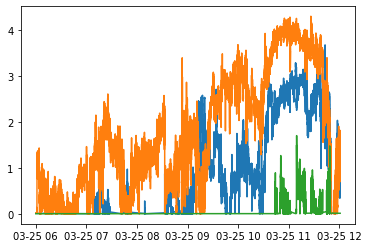

In [104]:
plt.plot(wind_df_hr[["BGSE_0", "BGSE_1", "BGSE_2"]])

In [105]:
# This dataframe is already at the high resolution (0.1s cadence). Setting aside a low resolution (cadence) version.
wind_df_lr = wind_df_hr.resample('5S').mean()
wind_df_lr.shape

(4332, 4)

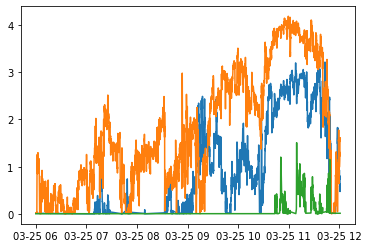

In [106]:
plt.plot(wind_df_lr[["BGSE_0", "BGSE_1", "BGSE_2"]])

### ACF function

Based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`

*Should `tsa.acf()` be set to fft=False? Default is True*

In [140]:
def compute_nd_acf(np_array, nlags, dt, show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.
    
    Args:

    - np_array: Array of shape (1,n) or (3,n)
    - nlags: The number of lags to calculate the ACF up to
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds

    Returns:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - R: The values of the ACF from lag 0 to nlags

    """
    if np_array.shape[0] == 3:
        acf = \
        sm.tsa.acf(np_array[0], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[1], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[2], fft=False, nlags=nlags)
        acf /= 3

    elif np_array.shape[0] == 1:
        acf = sm.tsa.acf(np_array[0], fft=False, nlags=nlags)

    else:
        raise ValueError("Array is not 3D or 1D. If after a 1D acf, try putting square brackets around the pandas series in np.array()")

    time_lags = np.arange(0, nlags+1)*dt   

    if show == True:

        fig, ax1 = plt.subplots()

        ax1.plot(time_lags, acf)
        ax2 = ax1.twiny()
        ax2.plot(np.arange(0, nlags+1), acf)

        ax1.set_xlabel('Lag (s)')
        ax2.set_xlabel('Lag ($\\tau$)')
        ax1.set_ylabel('Autocorrelation')
        plt.show()

    return time_lags, acf

Scalar version

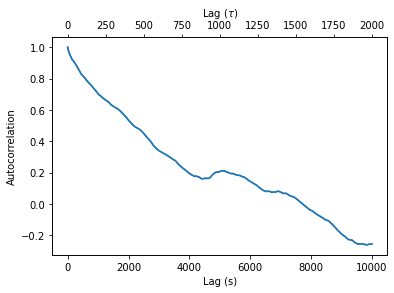

In [141]:
time_lags_lr, r_scalar_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0]), nlags=2000, dt = 5, show = True)

Vector version (same function, automatically detects). The following low-res ACF will be used for calculating the outer scale

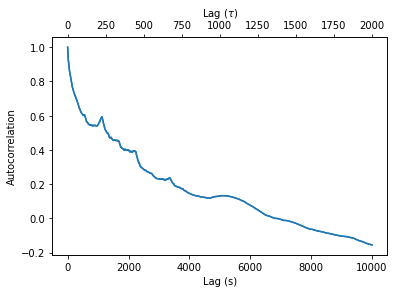

In [142]:
time_lags_lr, r_vec_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0, wind_df_lr.BGSE_1, wind_df_lr.BGSE_2]), nlags=2000, dt = 5, show = True)

The following high-res ACF will be used for calculating the Taylor scale. *This takes about 2.5 minutes to run*.

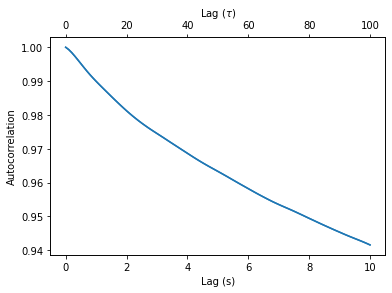

In [110]:
time_lags_hr, r_vec_hr = compute_nd_acf(np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), nlags=100, dt = 0.1, show = True)

### Outer scale functions

Using Kevin's function for computing outer scale using $1/e$ trick

In [145]:
# import importlib
# import utils
# importlib.reload(utils)
# lambda_outer_exp_trick = utils.estimate_correlation_scale(time_lags_lr, r_vec_lr, show = True)

from utils import estimate_correlation_scale as compute_outer_scale_exp_trick, exp_fit, para_fit
lambda_outer_exp_trick = compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr)
lambda_outer_exp_trick

2264.478

Adapting Kevin's function for computing outer scale using exponential fit: from `compute_correlation_time_scale()`

$$f(r)=\exp(-r/\lambda_c)$$

In [143]:
def compute_outer_scale_exp_fit(time_lags, acf, seconds_to_fit, show=False):

    dt = time_lags[1]-time_lags[0]
    num_lags_for_lambda_c_fit = int(seconds_to_fit/dt)
    c_opt, c_cov = curve_fit(
        exp_fit, time_lags[:num_lags_for_lambda_c_fit], acf[:num_lags_for_lambda_c_fit], p0=1000)
    lambda_c = c_opt[0]

    if show == True:
        ax = plt.gca()
        #ax.set_ylim(-.2, 1.2)
        plt.plot(time_lags, acf, label = "Autocorrelation")
        plt.plot(
            np.array(range(int(seconds_to_fit))),
            exp_fit(
                np.array(range(int(seconds_to_fit))),
                *c_opt
            ),
            'r-', 
            label = "Exponential fit")
        # box_color = 'grey' if lambda_c > 50 else 'red'
        # ax.text(time_lags[-1]*(5/10), 0.9, f'$\lambda_c$: {round(lambda_c, 1)}s', style='italic', fontsize=10,
        #         bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        ax.set_xlabel('Lag (s)')
        #ax2.set_xlabel('Lag ($\\tau$)')
        plt.legend()
        plt.show()
    
    return lambda_c


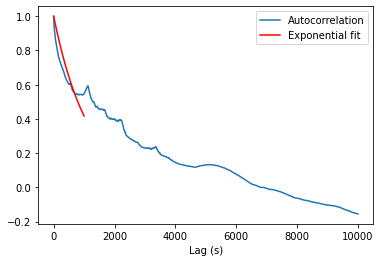

1143.686490965235

In [144]:
lambda_outer_exp_fit = compute_outer_scale_exp_fit(time_lags_lr, r_vec_lr, seconds_to_fit = 1000, show = True)
lambda_outer_exp_fit

Creating function for computing outer scale as integral of the ACF

$$\lambda_C=\int_0^\infty R(\tau)d\tau$$

In [114]:
def compute_outer_scale_integral(time_lags, acf):
    # Compute the area using the composite trapezoidal rule.
    area = np.trapz(y = acf, x = time_lags)
    print("Area (trapz) =", area)

    # Compute the area using the composite Simpson's rule.
    area = scipy.integrate.simps(y = acf, x = time_lags)
    print("Area (simps) =", area)

    return area

In [115]:
lambda_outer_int = compute_outer_scale_integral(time_lags_lr, r_vec_lr)

Area (trapz) = 1651.2273853521172
Area (simps) = 1651.217593118197


### Taylor scale function
Taken from Kevin's `compute_taylor_time_scale()`, which uses the parabolic fit method

In [138]:
def compute_taylor_scale(time_lags, acf, seconds_to_fit, show=False):
    dt = time_lags[1]-time_lags[0]
    num_lags_for_lambda_t_fit = int(seconds_to_fit/dt)

    t_opt, t_cov = curve_fit(
        para_fit,
        time_lags[:num_lags_for_lambda_t_fit],
        acf[:num_lags_for_lambda_t_fit],
        p0=10)
    lambda_t = (-1*t_opt[0])**-.5

    if show == True:
        ax = plt.gca()
        ax.set_ylim(-.2, 1.2)
        plt.plot(time_lags, acf, label = "Autocorrelation")
        plt.plot(
            np.array(range(int(1.1*lambda_t))),
            para_fit(np.array(range(int(1.1*lambda_t))), *t_opt),
            '-y',
            label = "Parabolic fit")
        ax.set_xlabel('Lag (s)')
        #ax.set_xlabel('Lag ($\\tau$)')
        plt.legend()
        plt.show()

    return lambda_t


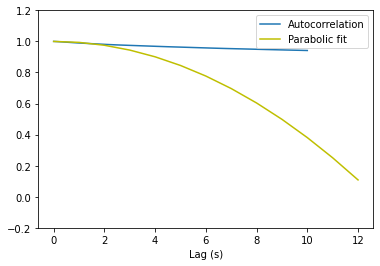

12.707799766485492

In [139]:
lambda_t = compute_taylor_scale(time_lags_hr, r_vec_hr, seconds_to_fit=2, show = True)
lambda_t